In [61]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame, concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet


In [62]:
df = pd.read_csv("products.csv")

In [63]:
df = df.drop(columns=['AnyPromo_Dollars', 'AnyPromo_Units', 'IncDollars',
       'IncUnits', 'NoPromo_Dollars', 'NoPromo_Units'])

In [64]:
df.head()

,GLMarket,UPC,GLPeriod,Dollars,BaseDollars,Units,Base_Units
0,Walgreens Corp Total TA,89231600047,w20190105,0.00,3.84,0.0,0.148
1,Walgreens Corp Total TA,9950010526,w20190119,0.00,0.66,0.0,0.349
2,Walgreens Corp Total TA,7780253340,w20190126,0.00,0.23,0.0,0.120
3,Walgreens Corp Total TA,6197200193,w20190216,0.00,1.63,0.0,1.054
4,Walgreens Corp Total TA,7780234935,w20190216,0.59,0.30,1.0,0.512


In [65]:
codes = df['UPC'].value_counts().index[:20]
codes_to_keep = [codes[0]]

In [66]:
df = df[df['UPC'].isin(codes_to_keep)]

In [67]:
df['GLPeriod'] = df['GLPeriod'].str.replace('w', '')
df['GLPeriod'] = pd.to_datetime(df['GLPeriod'], format='%Y%m%d')


In [68]:
df = df.set_index('GLPeriod')

In [69]:
df['value'] = df['Base_Units']
df = df['value']
df = df.sort_index()
df

GLPeriod
2017-08-05    314.527
2017-08-12    253.088
2017-08-19    212.617
2017-08-26    264.292
2017-09-02    272.562
               ...   
2020-10-03    118.512
2020-10-10     91.402
2020-10-17    100.281
2020-10-24    102.301
2020-10-31    127.428
Name: value, Length: 170, dtype: float64

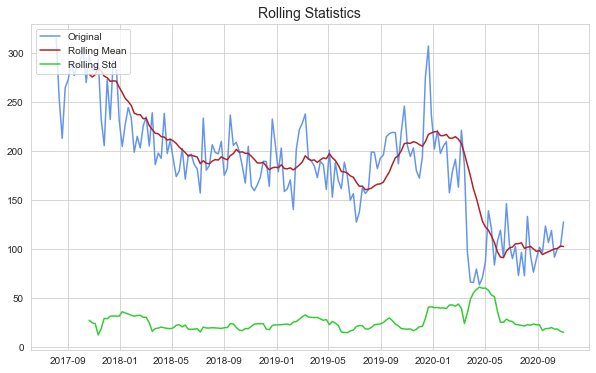

ADF Statistic: -1.783
p-value: 0.389
##################################
Critical Values:
1%: -3.471
5%: -2.879
10%: -2.576
##################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [70]:
def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12)

In [71]:
df = df.reset_index()

In [72]:
# Box-Cox transformation
df['value'], _ = boxcox(df['value'])

In [73]:
transformed_values, lambda_value = boxcox(df['value'])
print(f"Lambda Value: {lambda_value}")

Lambda Value: 0.9995692755530226


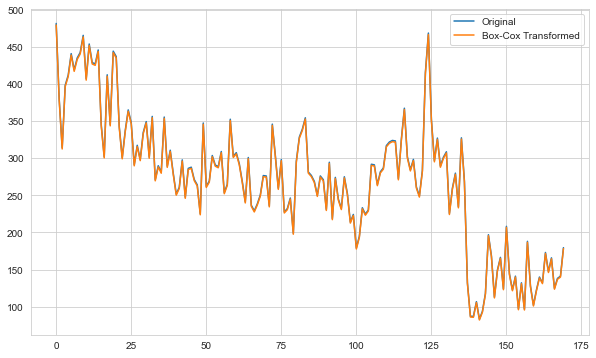

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(df['value'], label='Original')
plt.plot(transformed_values, label='Box-Cox Transformed')
plt.legend()
plt.show()

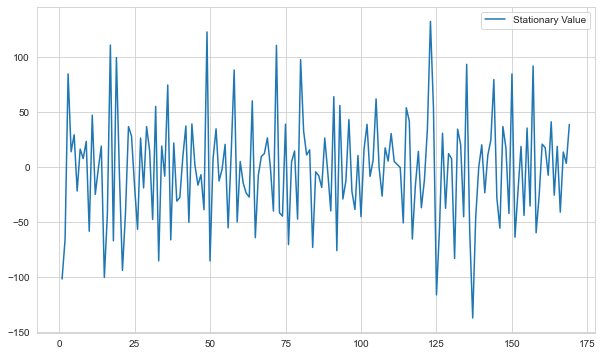

In [75]:
# First-order differencing
df['value'] = df['value'] - df['value'].shift(1)
df.dropna(subset=['value'], inplace=True)
# Visualize the stationary series
plt.figure(figsize=(10, 6))
plt.plot(df['value'], label='Stationary Value')
plt.legend()
plt.show()

In [76]:
df = df.set_index('GLPeriod')
print(df['value'].isnull().sum())

0


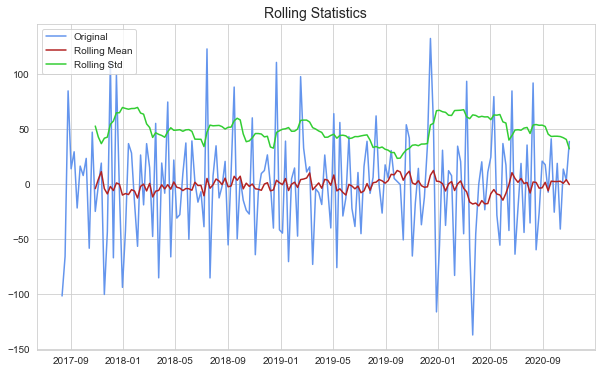

ADF Statistic: -7.025
p-value: 0.0
##################################
Critical Values:
1%: -3.471
5%: -2.88
10%: -2.576
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [77]:
adfuller_test(df, window = 12)

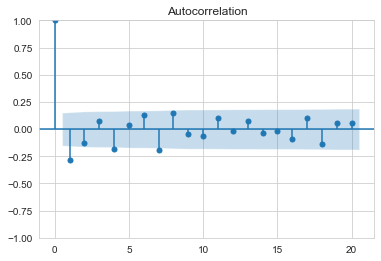

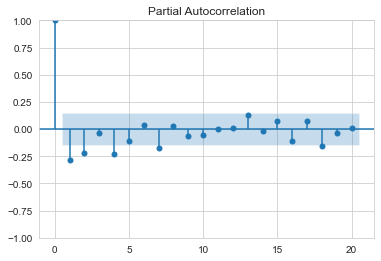

In [78]:
plot_acf(df, lags=20)  
plt.show()
plot_pacf(df, lags=20) 
plt.show()

In [79]:
split_point = int(len(df) * 0.8)  
train_data = df[:split_point]
test_data = df[split_point:]

In [80]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 1))
results = model.fit()

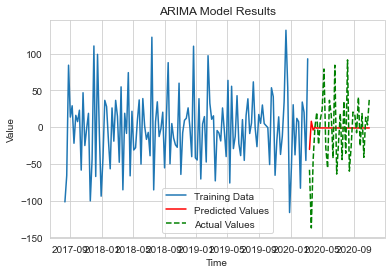

In [81]:
import matplotlib.pyplot as plt
# Plot train set
plt.plot(train_data, label='Training Data')

# Plot predicted values op test set
forecast = results.get_forecast(steps=len(test_data))
predicted_values = forecast.predicted_mean
plt.plot(test_data.index, predicted_values, color='red', label='Predicted Values')

# Plot actual values op de test set
plt.plot(test_data.index, test_data, label='Actual Values', linestyle='--', color='green')

# labels + legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Model Results')
plt.legend()
plt.show()

In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, predicted_values)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 37.17
MSE: 2203.70
RMSE: 46.94


MAE: 36.76
MSE: 2040.62
RMSE: 45.17


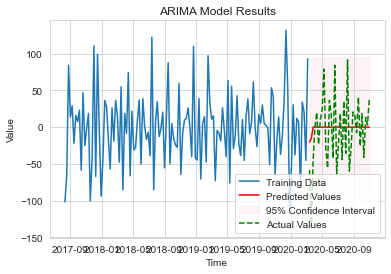

In [83]:
from pmdarima import auto_arima


# Split the data into training and testing sets (adjust the split point as needed)
split_point = int(len(df) * 0.8)
train_data = df[:split_point]
test_data = df[split_point:]

# Fit an automatic ARIMA model
model = auto_arima(train_data, seasonal=False, m=12)

# Get predictions for the testing set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

# Calculate evaluation metrics
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)

# Print or use the metrics as needed
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

# Visualize the results (optional)
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, forecast, label='Predicted Values', color='red')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.2, label='95% Confidence Interval')
plt.plot(test_data.index, test_data, label='Actual Values', linestyle='--', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Model Results')
plt.legend()
plt.show()

In [84]:
test_data

,value
GLPeriod,
2020-03-14,-58.049146
2020-03-21,-137.174594
2020-03-28,-45.341310
2020-04-04,-0.325700
2020-04-11,19.927843
2020-04-18,-23.586508
2020-04-25,10.546551
2020-05-02,24.214064
2020-05-09,79.111937


In [85]:
forecast

2020-03-14   -20.195152
2020-03-21   -15.625356
2020-03-28     0.000000
2020-04-04     0.000000
2020-04-11     0.000000
2020-04-18     0.000000
2020-04-25     0.000000
2020-05-02     0.000000
2020-05-09     0.000000
2020-05-16     0.000000
2020-05-23     0.000000
2020-05-30     0.000000
2020-06-06     0.000000
2020-06-13     0.000000
2020-06-20     0.000000
2020-06-27     0.000000
2020-07-04     0.000000
2020-07-11     0.000000
2020-07-18     0.000000
2020-07-25     0.000000
2020-08-01     0.000000
2020-08-08     0.000000
2020-08-15     0.000000
2020-08-22     0.000000
2020-08-29     0.000000
2020-09-05     0.000000
2020-09-12     0.000000
2020-09-19     0.000000
2020-09-26     0.000000
2020-10-03     0.000000
2020-10-10     0.000000
2020-10-17     0.000000
2020-10-24     0.000000
2020-10-31     0.000000
Freq: W-SAT, dtype: float64